In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
from matplotlib.colorbar import Colorbar 
import pdb
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar

In [2]:
dfmg2018 = pd.read_csv("dfmg_corrected_DIST_IS_GL.csv")
dfgamma2018 = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg2018['gamman'] = dfgamma2018['gamman']
del dfmg2018['Unnamed: 0']
dfmg2018.loc[:,'JULD'] = pd.to_datetime(dfmg2018.loc[:, 'JULD'])
dfmg2018.loc[(dfmg2018['gamman'] < 0), "gamman"] = np.nan

In [3]:
dfmg2018["DIST_min"] = dfmg2018.loc[:, ["DIST_GLINE", "DIST_ISE"]].min(axis=1)

In [4]:
df2020 = pd.read_csv("meop2020.csv")

In [5]:
count = dfmg2018.PROFILE_NUMBER.max() + 1
i = 0
grouped = df2020.groupby(['PROFILE_NUMBER'])
for name, group in grouped:
    df2020.loc[group.index, 'PROFILE_NUMBER'] = count
    #print(i, count)
    count+=1
    i += 1

In [6]:
df2020["JULD"] = pd.to_datetime(df2020.loc[:, 'JULD'])

In [7]:
dfmg = pd.concat([dfmg2018, df2020], ignore_index=True, sort=False)

In [8]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_min'] <= 50
gline_le_100km = dfmg['DIST_min'] <= 100
gline_le_150km = dfmg['DIST_min'] <= 150
gline_le_25km = dfmg['DIST_min'] <= 25
gline_le_75km = dfmg['DIST_min'] <= 75

sel_echodepth_3000 = dfmg.ECHODEPTH > -3000
sel_echodepth_1000 = dfmg.ECHODEPTH > -1000

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/aditya/anaconda3/envs/pyocean35/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [63]:
!mkdir ./Images/MEOP2020

In [9]:
def return_CT_mean(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = df.loc[mask, var].count()
    
    error = np.sqrt(CTerrorMean**2 + (1.96 * CTsd / np.sqrt(CTcount))**2)
    
    return CTmean , error

0 10
1 361
2 787
3 171


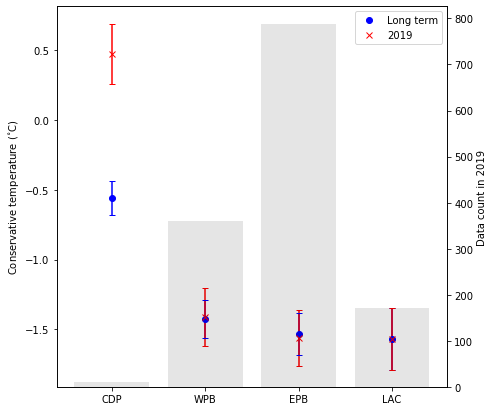

In [31]:
plt.close(1)
plt.figure(1, figsize=(7,7))

ax = plt.subplot()

regions = [CDP, WPB, EPB, LAC]
names = ["CDP", "WPB", "EPB", "LAC"]

dfsel_2019_Jan = (dfmg.JULD.dt.year == 2019) #& (dfmg.JULD.dt.month == 1)
x_axis = np.arange(len(regions))
month_sel = (dfmg.JULD.dt.month == 1) | (dfmg.JULD.dt.month == 2)
ax_right = ax.twinx()

for i in range(len(regions)):
    regional_bottom_CTEMP_mean_2019, regional_bottom_CTEMP_error_2019  = return_CT_mean(dfmg, 
                                              (regions[i] & dfsel_2019_Jan 
                                              & deepMask250 & sel_echodepth_3000
                                              & ~gline_le_75km), var='CTEMP')
    regional_bottom_CTEMP_mean_longTerm, regional_bottom_CTEMP_error_longTerm = return_CT_mean(dfmg, 
                                        (regions[i] & month_sel & deepMask250 & sel_echodepth_3000
                                              & ~gline_le_75km), var="CTEMP")
    
    data_count_2019 = dfmg.loc[regions[i] & dfsel_2019_Jan & deepMask250 & sel_echodepth_1000
                                              & ~gline_le_75km].CTEMP.count()
    print(i, data_count_2019)
    
    ax.errorbar(x_axis[i], regional_bottom_CTEMP_mean_longTerm, yerr = regional_bottom_CTEMP_error_longTerm,
               marker="o", color="b", label="Long term", capsize=3, ls='')
    ax.errorbar(x_axis[i], regional_bottom_CTEMP_mean_2019, yerr= regional_bottom_CTEMP_error_2019, 
                marker = "x", color="r", label="2019", capsize=3, ls='')
    
    
    ax_right.bar(x_axis[i], [data_count_2019], alpha=0.1, color='k')
    #ax_right.set_yscale("log")
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        ax.legend(handles, labels, loc='upper right',numpoints=1)

ax.set_xticks(np.arange(len(regions)))    
ax.set_xticklabels(names)
ax.set_ylabel("Conservative temperature ($^{\circ}$C)")
ax_right.set_ylabel("Data count in 2019")
plt.savefig("./Images/MEOP2020/Jan_Feb_comparison.pdf", dpi=300, bbox_inches="tight")
#ax.set_ylim(-2, 0)
plt.show()

WPB 361 -1.4107755883973874
EPB 787 -1.5609453557843191
LAC 171 -1.5674607066863921


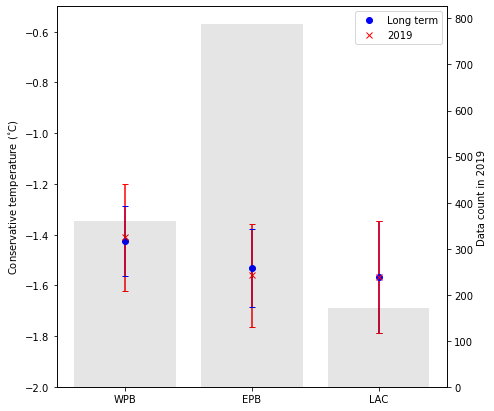

In [29]:
plt.close(1)
plt.figure(1, figsize=(7,7))

ax = plt.subplot()

regions = [WPB, EPB, LAC]
names = ["WPB", "EPB", "LAC"]

dfsel_2019_Jan = (dfmg.JULD.dt.year == 2019) #& (dfmg.JULD.dt.month == 1)
x_axis = np.arange(len(regions))
month_sel = (dfmg.JULD.dt.month == 1) | (dfmg.JULD.dt.month == 2)
ax_right = ax.twinx()

for i in range(len(regions)):
    regional_bottom_CTEMP_mean_2019, regional_bottom_CTEMP_error_2019  = return_CT_mean(dfmg, 
                                              (regions[i] & dfsel_2019_Jan 
                                              & deepMask250 & sel_echodepth_3000
                                              & ~gline_le_75km), var='CTEMP')
    regional_bottom_CTEMP_mean_longTerm, regional_bottom_CTEMP_error_longTerm = return_CT_mean(dfmg, 
                                        (regions[i] & month_sel & deepMask250 & sel_echodepth_3000
                                              & ~gline_le_75km), var="CTEMP")
    
    data_count_2019 = dfmg.loc[regions[i] & dfsel_2019_Jan & deepMask250 & sel_echodepth_1000
                                              & ~gline_le_75km].CTEMP.count()
    print(names[i], data_count_2019, regional_bottom_CTEMP_mean_2019)
    
    ax.errorbar(x_axis[i], regional_bottom_CTEMP_mean_longTerm, yerr = regional_bottom_CTEMP_error_longTerm,
               marker="o", color="b", label="Long term", capsize=3, ls='')
    ax.errorbar(x_axis[i], regional_bottom_CTEMP_mean_2019, yerr= regional_bottom_CTEMP_error_2019, 
                marker = "x", color="r", label="2019", capsize=3, ls='')
    
    
    ax_right.bar(x_axis[i], [data_count_2019], alpha=0.1, color='k')
    #ax_right.set_yscale("log")
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        ax.legend(handles, labels, loc='upper right',numpoints=1)
        
ax.set_xticks(np.arange(len(regions)))    
ax.set_xticklabels(names)
ax.set_ylabel("Conservative temperature ($^{\circ}$C)")
ax_right.set_ylabel("Data count in 2019")
plt.savefig("./Images/MEOP2020/Jan_Feb_comparison_woCDP.pdf", dpi=300, bbox_inches="tight")
ax.set_ylim(-2, -0.5)
plt.show()

In [18]:
dfsel2019 = (dfmg.JULD.dt.year == 2019) & (dfmg.JULD.dt.month == 2)
bottom_CTEMP_mean_2019, bottom_CTEMP_error_2019 = return_CT_mean(dfmg, 
                                 (dfsel2019 & LAC & deepMask250 & sel_echodepth_3000
                                  & ~gline_le_75km), var="CTEMP")

In [20]:
print(bottom_CTEMP_mean_2019, bottom_CTEMP_error_2019)

-1.739379964200252 0.2114368998493492


In [27]:
dfsel = df2020.JULD.dt.year == 2019
df2020[dfsel].CTEMP.mean()

0.04752624731902328